# Basic thrust model for satellite engines

Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please visit: http://tudat.tudelft.nl/LICENSE.

## Objectives

This example demonstrates the application of a basic custom class to model the thrust of a satellite. 

Consider the orbit of JUICE with respect to Ganymede. The goal will be to increase the inclination of the orbit, while keeping the nodes constant. Theoretically speaking, the easiest way to do this is by one or more impulsive maneuvers at the nodes of the orbit. Naturally, in reality this thrust will not be impulsive, but the thrust will be applied over a finite duration.

In this example, thrust is implemented to be provided when the true longitude of the spacecraft is within 2 degrees of one of the nodes. Note that parametrizing the thrust as a function of the true longitude is likely not an optimal choice, but it will suffice for this example. The maximum thrust magnitude $T_{max}$ is used when the thrust is on. Introducing such a discontinuity in the dynamical model is again likely not an optimal choice, but will suffice.
In addition to the acceleration from the thrust, a basic model is set up, consisting of the following accelerations:

- Spherical harmonic gravity accelerations from Ganymede and Jupiter. Their gravity fields will be expanded to D/O 2/2 and 4/0 respectively.
- Third body forces will include those of the Sun, Saturn, Europa, Io and Callisto. 

The mass of the vehicle is propagated using a mass rate model consistent with the engine thrust used.

How to set up dependent variables to save the mass and altitude of the vehicle over time is demonstrated.

Finally, some post-processing is performed to analyze the retrieved results.

## Import statements

The required import statements are made here at the beginning of the code.

Some standard modules are first loaded: `numpy` and `matplotlib.pyplot`.

The different modules of `tudatpy` that will be used are then imported. We include here the loading of the standard spice kernels as well as the JUICE spice kernel. This is not a standard kernel included in SPICE, and hence an associated file will need to be provided as input, containing the relevant data.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from tudatpy.util import result2array
from tudatpy import constants
from tudatpy.interface import spice
from tudatpy import dynamics
from tudatpy.dynamics import environment, environment_setup, propagation_setup, simulator
from tudatpy.astro import element_conversion, time_representation

# Load spice kernels.
spice.load_standard_kernels()
spice.load_kernel("input/juice_mat_crema_5_1_150lb_v01.bsp")

## Environment setup

Let’s create the environment for our simulation. This setup covers the creation of (celestial) bodies, vehicle(s), and environment interfaces.

### Create the bodies

The required bodies will first be created. Note that this involves creation of a simple atmosphere for Ganymede as well as including the radiation pressure settings for JUICE. Please refer to the [Environment Models](https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/environment_setup/environment_models.html) in the user guide for more details.

In [2]:
# Create settings for celestial bodies
bodies_to_create = ["Ganymede", "Sun", "Jupiter", "Saturn", "Europa", "Io", "Callisto"]
global_frame_origin = 'Ganymede'
global_frame_orientation = 'ECLIPJ2000'
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

# Add empty body settings for the spacecraft
body_settings.add_empty_settings("JUICE")

# Add mass property to spacecraft
body_settings.get("JUICE").constant_mass = 2E3


# Create radiation pressure target model for spacecraft
reference_area_radiation = 100.0
radiation_pressure_coefficient = 1.2
occulting_bodies_dict = dict()
occulting_bodies_dict["Sun"] = ["Ganymede"]
body_settings.get("JUICE").radiation_pressure_target_settings = environment_setup.radiation_pressure.cannonball_radiation_target(
    reference_area_radiation, radiation_pressure_coefficient, occulting_bodies_dict )

# Create environment
bodies = environment_setup.create_system_of_bodies(body_settings)


### Define the thrust guidance settings

Let's now define the aspects of the body related to thrust: its orientation and its engine. This is done by defining a `ThrustGuidance` class that will contain functions that will calculate the thrust magnitude and thrust direction at any point in time.

The class takes as input `maximum_thrust`, which defines what the constant value of the thrust will be when turned on in Newtons; `true_longitude_threshold`, which defines the range in degrees within which the thrust will be turned on, as measured from either of the nodes; `bodies` is the list of bodies created of type `SystemOfBodies`. Note that, in this class the thrust direction and magnitude are computed entirely independently (despite the fact that some computations are then done twice) to reduce the complexity of the example.

Then, the `rotation_model_settings` and `thrust_magnitude_settings` are set up, which complete the thrust model.

In [3]:
class ThrustGuidance:

    def __init__(self,
                 maximum_thrust: float,
                 true_longitude_threshold: float,
                 bodies: environment.SystemOfBodies):
        self.maximum_thrust = maximum_thrust
        self.true_longitude_threshold = true_longitude_threshold
        self.bodies = bodies

    def compute_thrust_direction(self, current_time: float):
        # Check if computation is to be done (if current_time is NaN, this signals the start of a new time step)
        if (current_time == current_time):

            # Retrieve current JUICE (keplerian) state w.r.t. Ganymede from environment
            current_cartesian_state = self.bodies.get_body('JUICE').state - self.bodies.get_body('Ganymede').state
            gravitational_parameter = self.bodies.get_body('Ganymede').gravitational_parameter
            current_keplerian_state = element_conversion.cartesian_to_keplerian(current_cartesian_state,
                                                                                gravitational_parameter)
            true_anomaly = current_keplerian_state[5]
            argument_of_pereapsis = current_keplerian_state[3]

            # Check if JUICE is within the threshold of being 'close' to one of the nodes.
            if (-self.true_longitude_threshold * np.pi / 180 <= (
                    np.pi - argument_of_pereapsis - true_anomaly) <= self.true_longitude_threshold * np.pi / 180):
                ang_momentum = np.cross(current_cartesian_state[:3], current_cartesian_state[3:])
                normalized_ang_momentum = ang_momentum / np.linalg.norm(ang_momentum)

                # Compute and return current thrust direction (3x1 vector): along orbital angular momentum vector
                thrust_direction = -normalized_ang_momentum

            elif (-self.true_longitude_threshold * np.pi / 180 <= (
                    2 * np.pi - argument_of_pereapsis - true_anomaly) <= self.true_longitude_threshold * np.pi / 180):
                ang_momentum = np.cross(current_cartesian_state[:3], current_cartesian_state[3:])
                normalized_ang_momentum = ang_momentum / np.linalg.norm(ang_momentum)

                # Compute and return current thrust direction (3x1 vector): along orbital angular momentum vector
                thrust_direction = normalized_ang_momentum

            else:
                thrust_direction = np.zeros([3, 1])

            return thrust_direction

        # If no computation is to be done, return zeros
        else:
            return np.zeros([3, 1])

    def compute_thrust_magnitude(self, current_time: float):
        # Check if computation is to be done
        if (current_time == current_time):

            # Retrieve current JUICE (keplerian) state w.r.t. Ganymede from environment
            current_cartesian_state = self.bodies.get_body('JUICE').state - self.bodies.get_body('Ganymede').state
            gravitational_parameter = self.bodies.get_body('Ganymede').gravitational_parameter
            current_keplerian_state = element_conversion.cartesian_to_keplerian(current_cartesian_state,
                                                                                gravitational_parameter)

            argument_of_pereapsis = current_keplerian_state[3]
            true_anomaly = current_keplerian_state[5]

            # Check if JUICE is within the threshold of being 'close' to one of the nodes and enable thrust if so
            if (-self.true_longitude_threshold * np.pi / 180 <= (
                    np.pi - argument_of_pereapsis - true_anomaly) <= self.true_longitude_threshold * np.pi / 180) or (
                    -self.true_longitude_threshold * np.pi / 180 <= (
                    2 * np.pi - argument_of_pereapsis - true_anomaly) <= self.true_longitude_threshold * np.pi / 180):
                thrust_magnitude = self.maximum_thrust

            else:
                thrust_magnitude = 0.0

            return thrust_magnitude
        # If no computation is to be done, return zeros
        else:
            return 0.0

In [4]:
# Create thrust guidance object (e.g. object that calculates direction/magnitude of thrust)
thrust_magnitude = 1  # N
true_longitude_threshold = 2  # degrees
thrust_guidance_object = ThrustGuidance(thrust_magnitude, true_longitude_threshold, bodies)

# Create engine model (default JUICE-fixed pointing direction) with custom thrust magnitude calculation
constant_specific_impulse = 300  # s
thrust_magnitude_settings = (
    propagation_setup.thrust.custom_thrust_magnitude_fixed_isp(
        thrust_guidance_object.compute_thrust_magnitude,
        constant_specific_impulse))
environment_setup.add_engine_model(
    'JUICE', 'MainEngine', thrust_magnitude_settings, bodies)

# Create vehicle rotation model such that thrust points in required direction in inertial frame
thrust_direction_function = thrust_guidance_object.compute_thrust_direction
rotation_model_settings = environment_setup.rotation_model.custom_inertial_direction_based(
    thrust_direction_function,
    "JUICE-fixed",
    "ECLIPJ2000")
environment_setup.add_rotation_model(bodies, "JUICE", rotation_model_settings)

## Propagation setup

Now that the environment is created, the propagation setup is defined.

First, the bodies to be propagated and the central bodies will be defined.
Central bodies are the bodies with respect to which the state of the respective propagated bodies is defined.

In [5]:
# Define bodies that are propagated
bodies_to_propagate = ["JUICE"]

# Define central bodies of propagation
central_bodies = ["Ganymede"]

### Create the acceleration model

First off, the acceleration settings that act on the JUICE are to be defined, which consists of the accelerations previously mentioned.

The defined acceleration settings are then applied to JUICE in a dictionary.

Finally, this dictionary is input to the propagation setup to create the acceleration models.

In [6]:
# Define accelerations acting on vehicle.

acceleration_settings_on_vehicle = dict(
    JUICE=[
        # Define the thrust acceleration from its direction and magnitude
        propagation_setup.acceleration.thrust_from_engine('MainEngine')
    ],
    Ganymede=
    [
        propagation_setup.acceleration.spherical_harmonic_gravity(2, 2)
    ],
    Jupiter=
    [
        propagation_setup.acceleration.spherical_harmonic_gravity(4, 0)
    ],
    Sun=
    [
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Saturn=
    [
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Europa=
    [
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Io=
    [
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Callisto=
    [
        propagation_setup.acceleration.point_mass_gravity()
    ]
)

# Create global accelerations dictionary.
acceleration_settings = {'JUICE': acceleration_settings_on_vehicle}

# Create acceleration models.
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies)

### Define the initial state

The initial state of JUICE that will be propagated is now defined. 

In this example, the initial state is retrieved from the JUICE spice kernel for a certain epoch, as defined at the start of the script. The final epoch is also given, making the propagation last a little over two weeks.

In [7]:
simulation_start_date = time_representation.DateTime(2035,7,28,14,24)
simulation_start_epoch = simulation_start_date.epoch()
simulation_end_epoch = simulation_start_epoch + 344.0 * constants.JULIAN_DAY / 24.0

# Define initial state (retrieve from SPICE).
system_initial_state = spice.get_body_cartesian_state_at_epoch(
    target_body_name='JUICE',
    observer_body_name='Ganymede',
    reference_frame_name='ECLIPJ2000',
    aberration_corrections='NONE',
    ephemeris_time=simulation_start_epoch)

### Define dependent variables to save

In this example, we are interested in saving not only the propagated state of the satellite over time, but also a set of so-called dependent variables that are to be computed (or extracted and saved) at each integration step.

[This page](https://py.api.tudat.space/en/latest/dependent_variable.html) of the tudatpy API website provides a detailed explanation of all the dependent variables that are available.

We will save the keplerian state of JUICE with respect to Ganymede, to verify whether we really do raise the inclination of the orbit. We will also save the mass of JUICE over time to ensure our mass propagation is also correctly performed. Lastly, we save norm of the thrust acceleration to verify whether the thrust we have set is indeed equal to 1N.

In [8]:
# Define required outputs
dependent_variables_to_save = [
    propagation_setup.dependent_variable.keplerian_state("JUICE", "Ganymede"),
    propagation_setup.dependent_variable.body_mass("JUICE"),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.thrust_acceleration_type, "JUICE", "JUICE"
    )
]

### Create the termination settings

Let's now define a set of termination settings. In this setup, we only define a single termination setting:
- Stop when JUICE reaches the specified end epoch (after a little over 14 days).

In a more realistic scenario, you may want to set multiple termination settings; next to terminating on time you can also choose to terminate at a certain mass (e.g. when you run out of propellant) or a certain altitude. For simplicity, we simply let the propagation run its full course and we will analyse the results after.

In [9]:
termination_settings = propagation_setup.propagator.time_termination(simulation_end_epoch)

### Create the integrator settings

The last step before starting the simulation is to set up the integrator that will be used.

In this case, an RK4 fixed step size integrator is used, with a given step size of 10 s. This is one of the most simple and reliable integrators available, and usually works good enough for a wide number of applications, provided there are relatively stable dynamics.

In [10]:
# Create numerical integrator settings.
fixed_step_size = 10.0
integrator_settings = propagation_setup.integrator.runge_kutta_fixed_step(
    fixed_step_size, coefficient_set=propagation_setup.integrator.CoefficientSets.rk_4
)

### Create the propagator settings

The propagator settings are now defined.

As usual, translational propagation settings are defined, using a Cowell propagator.

Next, mass propagation settings are also defined. The mass rate from the vehicle is set up to be consistent with the thrust used. The vehicle then loses mass as it loses propellant.

Finally, a multitype propagator is defined, encompassing both the translational and the mass propagators.

## Coupled dynamics
If you have used Tudat before, you are most probably familiar with what _translational propagators_ are. Possibly, you are also familiar with combined translational-mass propagations. These are just an example of a **multi-type propagation**. The way Tudat deals with these multi-type propagations is by creating the appropriate "single-type" propagation settings for each type of dynamics, and then putting them all together at then end in the _multi-type propagator settings_. Thus, we will follow the same process here. For more details, see [multi-type propagation documentation](https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/propagation_setup/multi_type.html).

As you will see in the code below - and can be deduced comparing the APIs for the [translational](https://py.api.tudat.space/en/latest/propagator.html#tudatpy.numerical_simulation.propagation_setup.propagator.translational), [mass](https://py.api.tudat.space/en/latest/propagator.html#tudatpy.numerical_simulation.propagation_setup.propagator.mass) and [multi-type](https://py.api.tudat.space/en/latest/propagator.html#tudatpy.numerical_simulation.propagation_setup.propagator.multitype) propagators - some of the inputs (namely the integrator settings, the initial time, the termination settings and the output variables) are identical between all three propagators - the two single-type and the one multi-type. In these overlaps, tudat will only read the "top level" arguments, i.e. those passed to the multi-type propagator and will ignore the rest. This means that these inputs can be left empty (`0`, `NaN` or `None`) for the single-type propagators. However, it is good practice to be self-consistent and pass the same inputs to all propagators. This facilitates the use of the single-type propagators for the simulation of only one type of dynamics while being consistent with the inputs of the multi-type simulation.

Below, we will begin by creating these common inputs and will then move on to the propagator-specific inputs.

In [11]:
# Create propagation settings.
translational_propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    system_initial_state,
    simulation_start_epoch,
    integrator_settings,
    termination_settings,
    output_variables=dependent_variables_to_save
)

# Create a mass rate model so that the vehicle loses mass according to how much thrust acts on it
mass_rate_settings = dict(JUICE=[propagation_setup.mass_rate.from_thrust()])
mass_rate_models = propagation_setup.create_mass_rate_models(
    bodies,
    mass_rate_settings,
    acceleration_models
)

# Create the mass propagation settings
mass_propagator_settings = propagation_setup.propagator.mass(
    bodies_to_propagate,
    mass_rate_models,
    [bodies.get("JUICE").mass],  # initial vehicle mass
    simulation_start_epoch,
    integrator_settings,
    termination_settings)

# Combine the translational and mass propagator settings
propagator_settings = propagation_setup.propagator.multitype(
    [translational_propagator_settings, mass_propagator_settings],
    integrator_settings,
    simulation_start_epoch,
    termination_settings,
    output_variables=dependent_variables_to_save)

# This prints the initial and final state to ensure that the propagation is ran successfully, and has not terminated earlier.
propagator_settings.print_settings.print_initial_and_final_conditions = True

## Propagate the orbit

The orbit of JUICE around Ganymede is now ready to be propagated.

This is done by calling the `create_dynamics_simulator()` function of the `dynamics, simulator module`.
This function requires the `system_of_bodies` and `propagator_settings` that have all been defined earlier.

After this, the history of the propagated state over time, containing both the position and velocity history, is extracted.
This history, taking the form of a dictionary, is then converted to an array containing 7 columns:
- Column 0: Time history, in seconds since J2000.
- Columns 1 to 3: Position history, in meters, in the frame that was specified in the `body_settings`.
- Columns 4 to 6: Velocity history, in meters per second, in the frame that was specified in the `body_settings`.

The same is done with the dependent variable history. The column indexes corresponding to a given dependent variable in the `dependent_variables_to_save` variable are printed when the simulation is run, when `create_dynamics_simulator()` is called.
Do pay attention that converting to an `ndarray` using the `result2array()` utility will shift these indexes because the first column (index 0) will then be the times.

In [12]:
# Create simulation object and propagate dynamics.
dynamics_simulator = simulator.create_dynamics_simulator(
    bodies, propagator_settings)

# Retrieve all data produced by simulation
propagation_results = dynamics_simulator.propagation_results

# Extract numerical solution for states and dependent variables
state_history = propagation_results.state_history
dependent_variable_history = propagation_results.dependent_variable_history

===============  STARTING SINGLE-ARC PROPAGATION  ===============

PRINTING INITIAL CONDITIONS
   Initial epoch: (311810, 1440) 
   Initial state (transpose): 
     -451153       523495 -3.06983e+06     -435.986       1673.8      352.034         2000

PRINTING FINAL CONDITIONS
   Clock time since propagation start: 16.8295
   Final epoch: (312154, 1440) 
   Final state (transpose): 
    187161     438605 3.0517e+06    562.567   -1694.34    214.963    1990.65

PROPAGATION FINISHED.




## Let's look at plots

We are now ready to do some post-processing, and look at our results! As mentioned before, we are interested in validating whether our maneuver was performed successfully, and whether the mass propagation has accurately kept track of the mass of JUICE over time.

As such, we'll plot the inclination, the mass of JUICE over time and add several plots to gain some confidence in the correct implementation of the thrust direction and magnitude, such as a plot of the magnitude as a function of the true longitude.

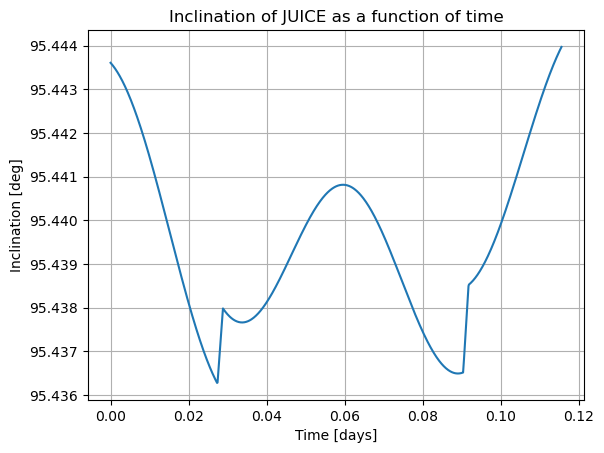

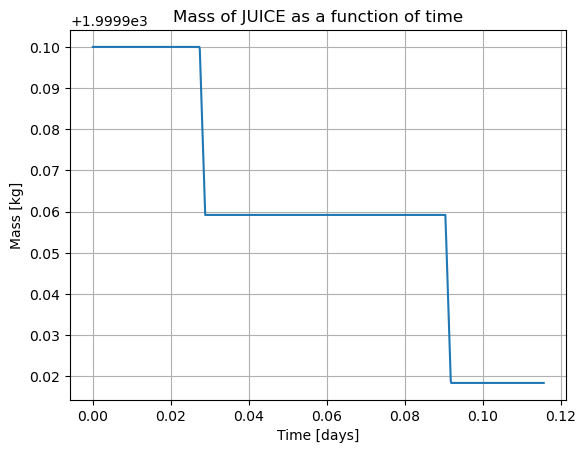

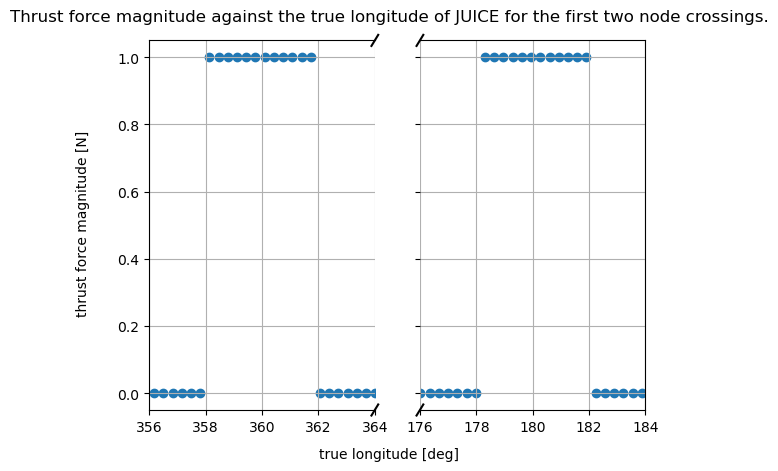

In [13]:
## PLOTS

# INDEX:      1,   2,   3,   4,     5,    6,     7,  8
# STATE:      x,   y,   z,   vx,    vy,   vz
# DEPENDENTS: a,   e,   i,   omega, RAAN, theta, mass, thrust_acceleration

states_array = result2array(state_history)
dependents_array = result2array(dependent_variable_history)
epochs = (states_array[:, 0] - states_array[0,0]) / 86400.0
time_label = 'Time [days]'

plt.figure()
plt.plot(epochs[:1000], np.degrees(dependents_array[:1000,3]), label = r'$i$')
plt.grid()
plt.xlabel(time_label)
plt.ylabel('Inclination [deg]')
plt.title('Inclination of JUICE as a function of time')

plt.figure()
plt.plot(epochs[:1000], dependents_array[:1000,7], label = r'$m$')
plt.grid()
plt.xlabel(time_label)
plt.ylabel('Mass [kg]')
plt.title('Mass of JUICE as a function of time')

f, (ax, ax2) = plt.subplots(1, 2, sharey=True)

# plot the thrust magnitude (the thrust acceleration times the mass) as a function of the true longitude. Note that these slices are taken by first having looked at a full plot, and realizing that
# it's quite hard to validate anything since the full plot is not detailed enough.
ax.scatter(np.rad2deg((dependents_array[:,6][230:260] + dependents_array[:,4][230:260])), dependents_array[:,7][230:260]*dependents_array[:,8][230:260])
ax2.scatter(np.rad2deg((dependents_array[:,6][770:800] + dependents_array[:,4][770:800])), dependents_array[:,7][770:800]*dependents_array[:,8][770:800])

# Limit our view of the mean anomaly to be within 4 degrees of the two nodes; they are our areas of interest.
ax.set_xlim(356, 364)  # outliers only
ax.grid()
ax2.set_xlim(176, 184)  # most of the data
ax2.grid()

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.xaxis.tick_bottom()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((- d,  + d), ( - d,  + d), **kwargs)  # bottom-right diagonal

f.text(0.5, 0.92, 'Thrust force magnitude against the true longitude of JUICE for the first two node crossings.', ha='center', fontsize = 12)
f.text(0.5, 0.01, 'true longitude [deg]', ha='center')
f.text(0.01, 0.5, 'thrust force magnitude [N]', va='center', rotation='vertical')


plt.show()

From the plots created, we can verify (and further analyze) a couple of things. First of all, note that the mass of the vehicle behaves as we would expect: save for some periods of time where the thrust is turned on, it remains constant. For the times where the thrust is turned on, the mass decreases linearly. From this point, we could also analyze whether the mass decrease is what we would expect from the thrust force the engine produces to gain further confidence in the results.

Note that the inclination also behaves as expected: at specific times, the inclination sharply increases, likely due to the applied thrust from the vehicle's engine. In order to gain more confidence in this assumption, two things can be done: First, the times at which the inclination rapidly increases can be compared with the times at which the mass decreases. From a visual analysis, they seem to match up. Second, it is useful to run two propagations, one where the engine's thrust acceleration is takes into account, and one where the engine's thrust acceleration is left out. The difference in kepler elements, and more specifically in our case, the inclination, should be (almost) entirely caused by the applied thrust. Since this model is an approximation of instantenously applied thrust, it is likely there will also be small variations in the other kepler elements. This is useful to realize when creating such a model.

Lastly, it's also useful to verify whether the thrust is applied at the correct times; within two degrees of either of the nodes. We can do this by plotting the thrust magnitude against the true longitude, defined as the sum of the true anomaly and the argument of pereapsis. From the last figure, we can conclude that, indeed, the thrust is non-zero within two degrees of either of the nodes, and zero everywhere else in the orbit.

Of course, this analysis can be extended to validate, for example, the direction of the applied thrust and, as said before, the other kepler elements. They can give deeper insights on how exactly thrust models influence the propagations.